Imports<br>
https://stackoverflow.com/questions/4383571/importing-files-from-different-folder

In [1]:
import sys
sys.path.append("../")
import json
import time
import pandas as pd
import ccxt
from config_py_files import config
from datetime import datetime
import numpy as np

In [2]:
import math
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt

In [3]:
from johansen import coint_johansen
import warnings
import itertools

In [4]:
start = time.time()
print('starting backtester...')

starting backtester...


SET EXCHANGE

In [5]:
# exchange_input = input("STRING INPUT: Please select 'testnet' or 'mainnet', else write 'default' for test: ")

exchange_input = "mainnet"
print(f"You entered {exchange_input}")

You entered mainnet


In [6]:
if exchange_input == "mainnet":
    exchange = ccxt.deribit({
        "apiKey": config.mainnet_api_key,
        "secret": config.mainnet_api_secret})
    exchange.set_sandbox_mode(False)
    print('mainnet set for backtest')
    api_dict = {"EXCHANGE_TYPE": "mainnet", "API_KEY":config.mainnet_api_key, "SECRET": config.mainnet_api_secret, "SOCKET": config.mainnet_socket}
elif exchange_input == "testnet" or exchange_input == "default":
    exchange = ccxt.deribit({
        "apiKey": config.testnet_api_key,
        "secret": config.testnet_api_secret})
    exchange.set_sandbox_mode(True)
    print('exchange testnet set for backtest')
    api_dict = {"EXCHANGE_TYPE": "testnet", "API_KEY":config.testnet_api_key, "SECRET": config.testnet_api_secret, "SOCKET": config.testnet_socket}
else:
    print('invalid exchange input!')
    sys.exit()

mainnet set for backtest


SET RISK PROFILE

In [7]:
# tradeable_pct_input = input("FLOAT INPUT: Please state proportion of account balance you wish to trade, \nbetween 0.01-1.0, else enter 'default' for 10%: ")

tradeable_pct_input = 1.0

In [8]:
if tradeable_pct_input == "default":
    balance_tradeable_percentage = 0.01
else:
    balance_tradeable_percentage = tradeable_pct_input

In [9]:
print(f"tradeable balance %age is {balance_tradeable_percentage}")

tradeable balance %age is 1.0


In [10]:
tradeable_pctage_dict = {"TRADEABLE_PCT": balance_tradeable_percentage}

SET SINCE DAY - OR HOW FAR BACK TO FETCH DATA FROM

In [11]:
# since_day_input = input("STRING INPUT: Please state how far back you want the backtest to run,\nin format YYYY-MM-DD_HH_MM_SS\ne.g. 2021-06-01_00_00, else write default: ")

since_day_input = "default"

In [12]:
if since_day_input == "default":
    since_day = '2021-06-01_00_00'
else: 
    since_day = since_day_input

SET COIN TYPE

In [13]:
# # coin_type_input = input("STRING INPUT: are you backtesting BTC or ETH instruments?: ")
# coin_type_input = "BTC"
# coin = coin_type_input
# print(f'selecting {coin} futures for backtest...')

In [14]:
lookback = 20
sl_std_dev = 1 #default is 1 standard deviation below and above bands

In [15]:
# front_vector = 0
# middle_vector = 0
# back_vector = 0

Checking what the ETH Futures look like for Deribit; testnet has fewer eth instruments - no options.

In [16]:
# markets = exchange.load_markets()
# markets = [market for market in markets if coin in market and "0-" not in market]
# print(f'printing {coin} futures markets...')
# for market in markets:
#     print(market)

In [17]:
# front_leg_input = input("STRING INPUT: look at the instruments available. What is the front leg to backtest? ")

# if front_leg_input in markets:
#     front_leg_instrument = front_leg_input
#     print(f"{front_leg_instrument} is front leg")
# else:
#     print(f"invalid instrument input!")
#     sys.close()


In [18]:
# mid_leg_input = input("STRING INPUT: What is the middle leg to backtest? ")

# if mid_leg_input in markets:
#     middle_leg_instrument = mid_leg_input
#     print(f"{middle_leg_instrument} is mid leg")
# else:
#     print(f"invalid instrument input!")
#     # sys.close()

In [19]:
# back_leg_input = input("STRING INPUT: What is the back leg to backtest? ")

# if back_leg_input in markets:
#     back_leg_instrument = back_leg_input
#     print(f"{back_leg_instrument} is back leg")
# else:
#     print(f"invalid instrument input!")
#     sys.close()

SET INSTRUMENTS

In [20]:
# print(f"legs to backtest are {front_leg_instrument}, {middle_leg_instrument}, {back_leg_instrument}")

dataframe builder function. SET SINCE DAY

In [25]:
def dataframe_builder(exchange, sym, tf, since_day):
    since = round(datetime.strptime(str(since_day), '%Y-%m-%d_%H_%M').timestamp()*1000)

    #get first leg of spread
    ohlcv = exchange.fetch_ohlcv(symbol=sym, timeframe=tf, since=since)

    # convert it into Pandas DataFrame
    df = pd.DataFrame(ohlcv, columns = ['Time', 'Open', 'High', 'Low', sym, 'Volume'])
    # df['Time'] = [datetime.fromtimestamp(float(time)/1000).strftime('%Y-%m-%d_%H_%M') for time in df['Time']]
    df.set_index('Time', inplace=True)
    df = df[[sym]]
    return df

In [26]:
def triple_df_builder(front_leg_instrument, middle_leg_instrument, back_leg_instrument, tf):
    #get december futures
    df_front_leg = dataframe_builder(exchange, front_leg_instrument, tf, since_day)

    #get september futures
    time.sleep(5)
    df_middle_leg = dataframe_builder(exchange, middle_leg_instrument, tf, since_day)

    #get upcoming futures
    time.sleep(5)
    df_back_leg = dataframe_builder(exchange, back_leg_instrument, tf, since_day)
    df = pd.concat([df_front_leg, df_middle_leg, df_back_leg], axis=1)
    
    #some contracts commence earlier than the others so we want to have the 3 instruments overlap 
    #for the butterfly spread to work
    df.dropna(inplace = True)

    # print(f'length of dataframe is {len(df)}')
    return df

In [28]:
def johansen_test(df):
    print('running Johansen test...')
    register_matplotlib_converters()

    # For checking cointegration
    sys.path.append("..")
    warnings.filterwarnings('ignore')

    # Run Johansen test on the whole dataset

    # Store the results of Johansen test after applying on the dataframe
    result = coint_johansen(df, 0, 1)

    # Print trace statistics and eigen statistics
    print ('--------------------------------------------------')
    print ('--> Trace Statistics')
    print ('variable statistic Crit-90% Crit-95%  Crit-99%')
    for i in range(len(result.lr1)):
        print ("r <= " + str(i), round(result.lr1[i], 4), round(result.cvt[i, 0],4), round(result.cvt[i, 1],4), round(result.cvt[i, 2],4))
    print ('--------------------------------------------------')
    print ('--> Eigen Statistics')
    print ('variable statistic Crit-90% Crit-95%  Crit-99%')
    for i in range(len(result.lr2)):
        print ("r <= " + str(i), round(result.lr2[i], 4), round(result.cvm[i, 0],4), round(result.cvm[i, 1],4), round(result.cvm[i, 2],4))

    #Print half-life, or time taken for data to revert to mean
    theta = result.eig[0]
    half_life = math.log(2)/theta
    print ('--------------------------------------------------')
    print ('--> Half Life')
    print (f"The expected holding period is {half_life} periods.")

    # Store the results of Johansen test
    half_df_length = len(df)/2
    lookback_johansen = int(round(half_df_length)) #set to half of whatever dataframe, always.
    result = coint_johansen(df[:lookback_johansen], 0, 1)

    # Store the value of eigenvector. Using this eigenvector, you can create the spread
    ev = result.evec

    # Take the transpose and use the first row of eigenvectors as it forms strongest cointegrating spread 
    ev = result.evec.T[0]

    # Normalise the eigenvectors by dividing the row with the first value of eigenvector
    ev = ev/ev[0]

    front_vector = round(ev[0], 2)
    middle_vector = round(ev[1],2)
    back_vector = round(ev[2],2)

    # Print the mean reverting spread
    print(f"\nCurrent Cointegrated Spread for {tf}= {front_vector}*{front_leg_instrument} + ({middle_vector})*{middle_leg_instrument} + ({back_vector})*{back_leg_instrument}")
    print(f"Johansen test performed on {df.index[-1]}")
    return [front_vector, middle_vector, back_vector]

In [30]:
def johansen_monthly(front_leg_instrument, middle_leg_instrument, back_leg_instrument, tf):
    df = triple_df_builder(front_leg_instrument, middle_leg_instrument, back_leg_instrument, tf)
    vectors = johansen_test(df)
    return df, vectors

In [31]:
def butterfly_sl_backtester(df, front_vector, middle_vector, back_vector, lookback, std_dev, sl_flag, sl_std_dev, one_way_fee):
    print('running new backtest...')    
    df['spread'] = df[front_leg_instrument]*front_vector + df[middle_leg_instrument]*middle_vector + df[back_leg_instrument]*back_vector

    # requires x and y plotting to be done in numpy arrays
    # print("Spread for Timeframe {0}, Lookback {1}, Std Deviation {2}".format(tf, lookback, std_dev))
    # spread_timestamps = list(df.index.values)
    # fig.plot(spread_timestamps, df["spread"], label="spread", width=50, height=15)    
    # fig.show()
    
    # Moving Average and Moving Standard Deviation
    df['moving_average'] = df.spread.rolling(lookback).mean()
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    # Upper band and lower band
    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    # Long entries
    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average

    # Short entries
    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average

    #binary positions tracking
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0

    # ------------------------- Stop Loss Logic -------------------------------
    if sl_flag:
        # Add a stop loss x standard deviation away from lower band.
        # For example, refer to the above markdown cell
        df['long_sl'] = df.spread < (df.lower_band - sl_std_dev*df.moving_std_dev)

        # Whenever the long_sl is True, set the positions_long_sl to 0
        df.loc[df.long_sl, 'positions_long_sl'] = 0

        # Whenever the price reverts to the mean, set the positions_long_sl to 1
        df.loc[df.long_exit, 'positions_long_sl'] = 1

        # Add a stop loss x standard deviation away from upper band.
        df['short_sl'] = df.spread > (df.upper_band + sl_std_dev*df.moving_std_dev)

        # Similar to above but for short side
        df.loc[df.short_sl, 'positions_short_sl'] = 0
        df.loc[df.short_exit, 'positions_short_sl'] = 1
        df = df.fillna(method='ffill')

        # Multiply with the positions column to include the impact of the stop loss
        df.positions_long = df.positions_long * df.positions_long_sl
        df.positions_short = df.positions_short * df.positions_short_sl

    # Fill NaN values
    df = df.fillna(method='ffill')

    # Consolidate the positions
    df['positions'] = df.positions_long + df.positions_short

    # Calculate spread difference
    df['spread_diff'] = df.spread-df.spread.shift(1)

    # Calculate portfolio value
    df['portfolio_value'] = abs(front_vector)*df[front_leg_instrument] + abs(middle_vector)*df[middle_leg_instrument] + abs(back_vector)*df[back_leg_instrument]

    # Calculate daily returns
    df['daily_returns'] = df.spread_diff / df['portfolio_value'].shift(1)

    # Calculate strategy returns
    df['strategy_returns'] = df.daily_returns  * df.positions.shift(1)


    # Calculate fresh entries
    # fresh longs & shorts, where previously positions = 0.
    # from adapting shift() - https://stackoverflow.com/questions/41399538/comparing-previous-row-values-in-pandas-dataframe
    
    df['fresh_entry'] = np.where(((df['positions']==-1) | (df['positions']==1)) & (df['positions'].shift()==0), True, False)

    # Calculate fresh exits
    df['fresh_exit'] = np.where(((df['positions'].shift()==-1) | (df['positions'].shift()==1)) & (df['positions']==0), True, False)

    # Calculate one way butterfly fees
    df['one_way_fee'] = np.where(((df['fresh_entry'] == True) | (df['fresh_exit']== True)), one_way_fee, 0)

    # Calculate net strategy returns, after fees
    df['net_strategy_returns'] = df["strategy_returns"] + df["one_way_fee"]

    df = df.dropna()

    # Calculate cumulative strategy returns
    df['cumret'] = ((df.net_strategy_returns+1)).cumprod()

    print("{0}, {1}, {2} Butterfly Returns with Timeframe {3}, Lookback {4}, Std Deviation {5}".format(front_leg_instrument, middle_leg_instrument, back_leg_instrument, tf,lookback, std_dev ))
    
    #PLOTTING NOT COMPATIBLE WITH .PY SCRIPT IN TERMINAL
    # df.cumret.plot(figsize=(10,5))
    # plt.title("{0}, {1}, {2} Butterfly Returns with Timeframe {3}, Lookback {4}, Std Deviation {5}".format(front_leg_instrument, middle_leg_instrument, back_leg_instrument, tf,lookback, std_dev ))
    # plt.xlabel('Date')  
    # plt.ylabel('Cumulative Returns')  
    # plt.legend()  
    # plt.show()
    
    ROI = df["cumret"].iloc[-1]
    ROI = ROI.item()
    print(f'ROI is {df["cumret"].iloc[-1]} for {tf}')
    print(f'length of {tf} dataframe is {len(df)}')
    
    #PLOTTING NOT COMPATIBLE WITH .PY SCRIPT IN TERMINAL
    df[['spread','moving_average',"lower_band",'upper_band']].plot(figsize=(10,4))
    plt.grid(True)
    plt.title("{0}, {1}, {2} Butterfly Bollinger Bands with Timeframe {3}".format(front_leg_instrument, middle_leg_instrument, back_leg_instrument, tf))
    plt.axis('tight')
    plt.ylabel('Price')
    
    return [front_leg_instrument, middle_leg_instrument, back_leg_instrument, tf, ROI,lookback, std_dev, front_vector, middle_vector, back_vector]

# Find Best Timeframe on Standard Bollinger Params

In [32]:
timeframes = list(exchange.timeframes.keys())

In [33]:
timeframes = timeframes[-8:]

In [34]:
print(timeframes)

['15m', '30m', '1h', '2h', '3h', '6h', '12h', '1d']


convert to dictionary to append dfs to later

In [35]:
tf_dictionary = dict.fromkeys(timeframes)

In [36]:
df_list = list()
tf_backtest_results = list()

In [37]:
markets = exchange.load_markets()
markets = [market for market in markets if "0-" not in market]
print(f'printing all futures markets...')
for market in markets:
    print(market)

printing all futures markets...
ETH-28JAN22
ETH-24JUN22
ETH-25MAR22
ETH-30SEP22
ETH-7JAN22
ETH-31DEC21
ETH-PERPETUAL
BTC-25MAR22
BTC-28JAN22
BTC-24JUN22
BTC-7JAN22
BTC-30SEP22
BTC-31DEC21
BTC-PERPETUAL


ETH-28JAN22 ETH-24JUN22 ETH-25MAR22
running Johansen test...
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r <= 0 958.5265 27.0669 29.7961 35.4628
r <= 1 277.9277 13.4294 15.4943 19.9349
r <= 2 3.4404 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r <= 0 680.5989 18.8928 21.1314 25.865
r <= 1 274.4873 12.2971 14.2639 18.52
r <= 2 3.4404 2.7055 3.8415 6.6349
--------------------------------------------------
--> Half Life
The expected holding period is 3.779199864647998 periods.

Current Cointegrated Spread for 15m= 1.0*ETH-28JAN22 + (0.41)*ETH-24JUN22 + (-1.39)*ETH-25MAR22
Johansen test performed on 1640937600000
printing head of dataframe...
               ETH-28JAN22  ETH-24JUN22  ETH-25MAR22
Time                                                
1637913600000      4363.90      4579.25      4463.85
1637914500000      4190.

IndexError: single positional indexer is out-of-bounds

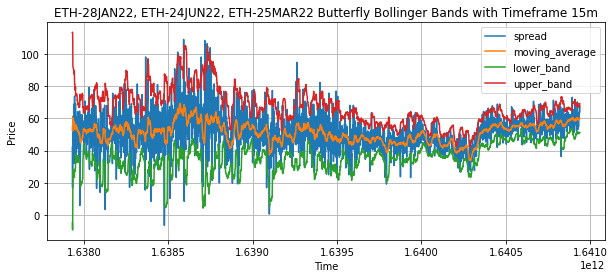

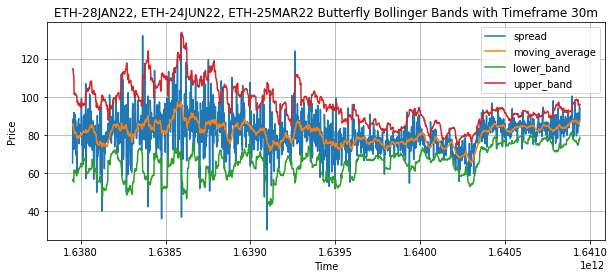

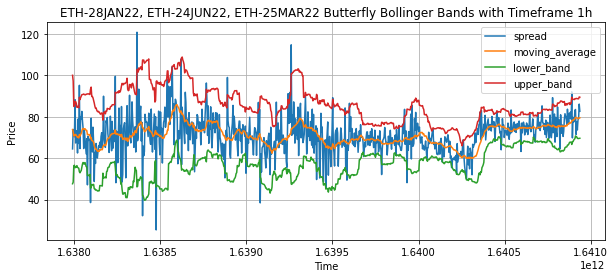

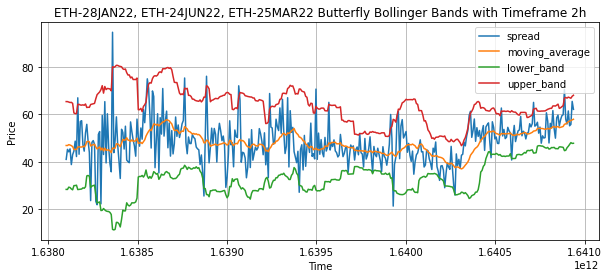

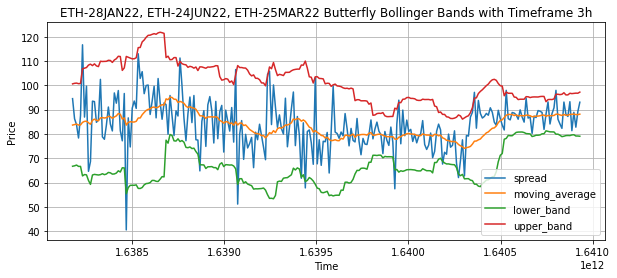

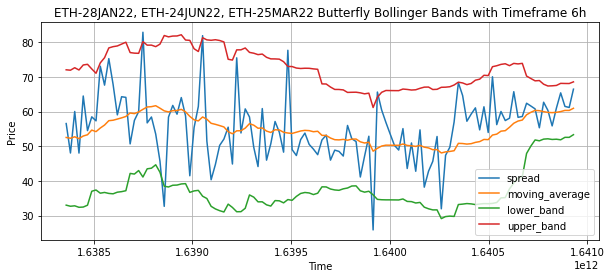

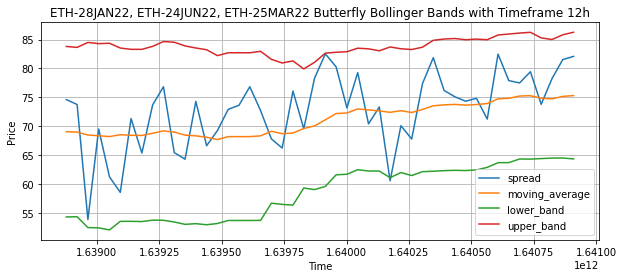

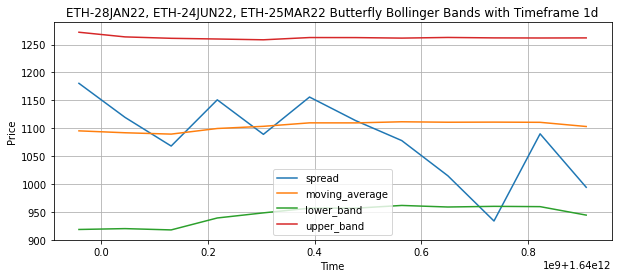

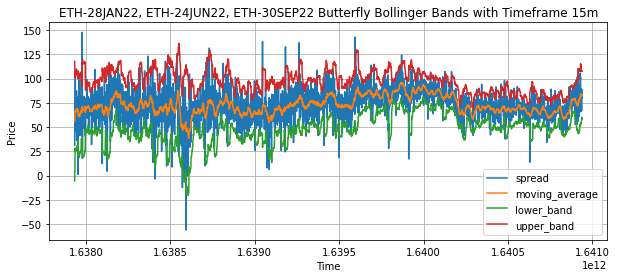

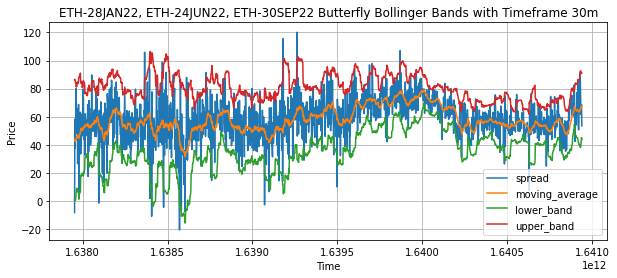

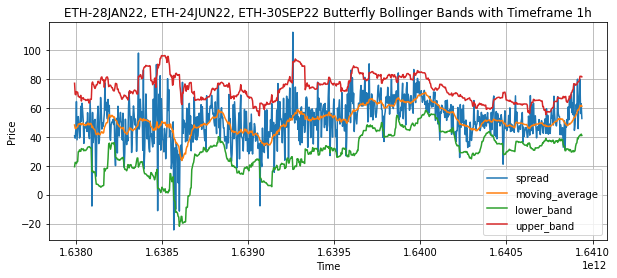

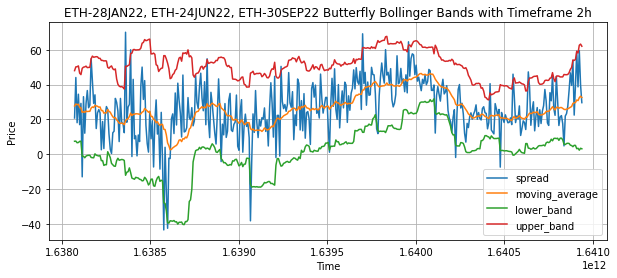

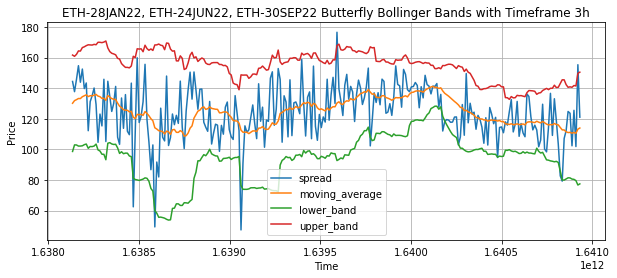

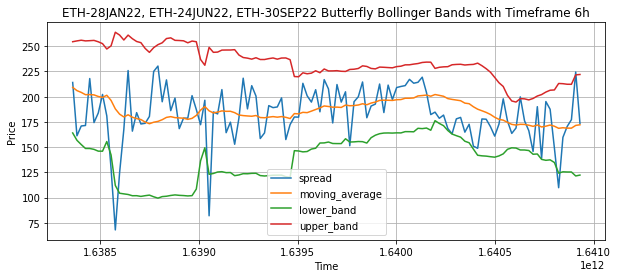

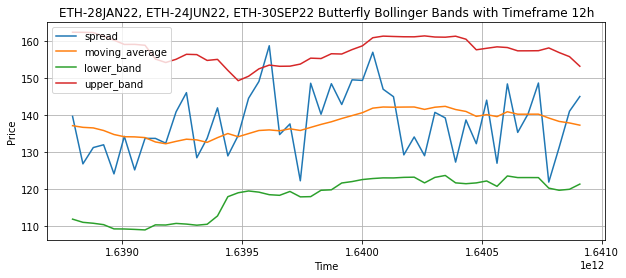

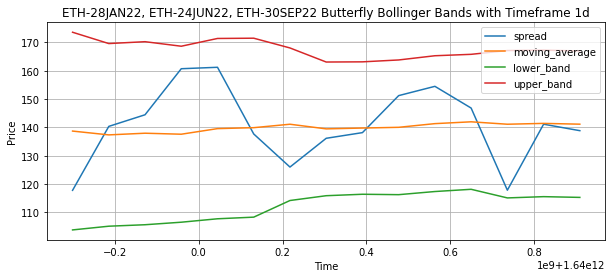

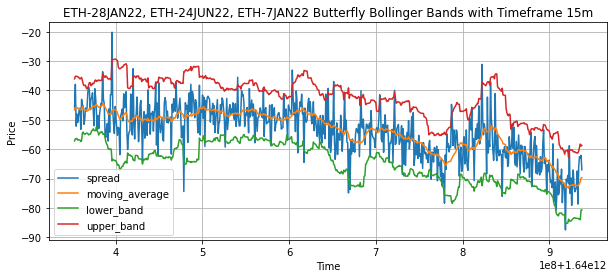

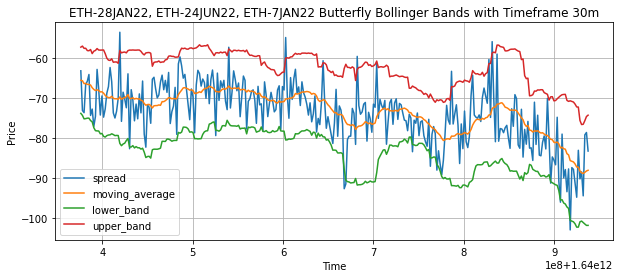

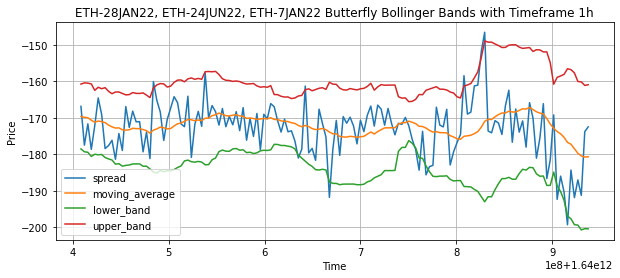

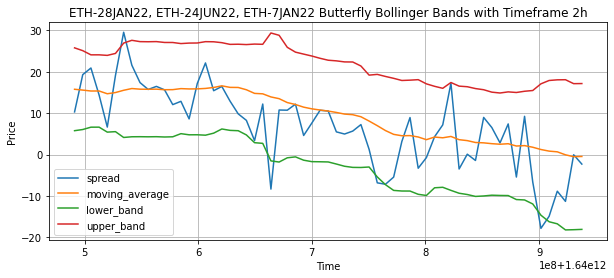

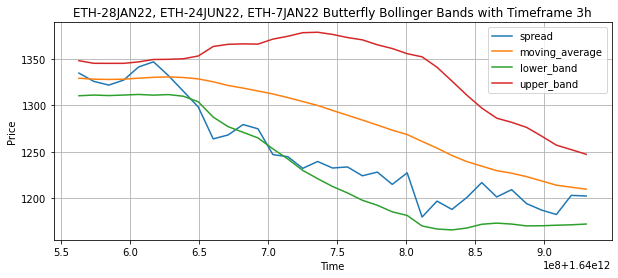

In [40]:
for combi in itertools.combinations(markets, 3):
    # print(combi)
    front_leg_instrument = str(combi[0])
    middle_leg_instrument = str(combi[1])
    back_leg_instrument = str(combi[2])
    print('backtesting fresh combination of 3 legs...')
    print(front_leg_instrument, middle_leg_instrument, back_leg_instrument)

    for tf in timeframes:
        #get the dfs
        df_and_vectors = johansen_monthly(front_leg_instrument, middle_leg_instrument, back_leg_instrument, tf)
        df_list.append(df_and_vectors[0])
        df = df_and_vectors[0]
        print('printing head of dataframe...')
        print(df.head())
        #printing all vectors...
        print('printing all vectors...')
        print(df_and_vectors[1])
        vectors = df_and_vectors[1]
        front_vector = vectors[0]
        middle_vector = vectors[1]
        back_vector = vectors[2]
        # run johansen on dfs + backtester, append all to list of lists
        tf_result = butterfly_sl_backtester(df, front_vector, middle_vector, back_vector, 20, 2, True, 1, -0.0015)
        tf_backtest_results.append(tf_result)
        time.sleep(5)

organize df list into dictionary organized by tfs

In [ ]:
tf_results_df = pd.DataFrame(tf_backtest_results, columns = ["front_leg", "mid_leg", "back_leg","tf", "ROI","lookback", "std_dev", "front_vector", "middle_vector", "back_vector"])
print('printing tf backtest results...')
print(tf_results_df)

In [ ]:
best_tf_params_index = tf_results_df["ROI"].idxmax()
print(tf_results_df.iloc[best_tf_params_index])

In [ ]:
results_dict = tf_results_df.iloc[best_tf_params_index].to_dict()
print(results_dict)

pick the tf with the best timeframe out of tf_dictionary

In [ ]:
for key in tf_df_dict:
  if key == results_dict["tf"]:
    print(f'the best tf for this backtest is {key}')
    df = tf_df_dict[key]

In [ ]:
print(df.tail())

# Backtesting Bollinger Parameters<br>
John Bollinger states that it's <br>
* 20 lookback - 2 Std Dev, <br>
* 10 lookback - 1.9 Std Dev,<br>
* 50 lookback - 2.1 Std Dev

In [ ]:
lookbacks_list = [10, 20, 50]
standard_deviations_list = [1.9, 2, 2.1]

esetting tf and eigenvectors as global variables because these won't change anymore.

In [ ]:
tf = results_dict["tf"]

In [ ]:
front_vector = results_dict["front_vector"]
middle_vector = results_dict["middle_vector"]
back_vector = results_dict["back_vector"]

In [ ]:
front_leg_dict = {"FRONT_LEG": front_leg_instrument}
mid_leg_dict = {"MID_LEG": middle_leg_instrument}
back_leg_dict = {"BACK_LEG": back_leg_instrument}

In [ ]:
bollinger_backtest_results = []

backtesting the lookbacks and standard deviations

In [ ]:
for lookback in lookbacks_list:
  for sd in standard_deviations_list:
    result = butterfly_sl_backtester(df, lookback, sd, True, 1)
    bollinger_backtest_results.append(result)

urn bollinger params backtest into a dataframe

In [ ]:
bollinger_results_df = pd.DataFrame(bollinger_backtest_results, columns = ["TF", "ROI","LOOKBACK", "STD_DEV", "FRONT_VECTOR", "MIDDLE_VECTOR", "BACK_VECTOR"])

In [ ]:
print('printing bollinger params backtest results...')
print(bollinger_results_df)

find largest ROI amount

In [ ]:
best_params_index = bollinger_results_df["ROI"].idxmax()
print('printing best bollinger params...')
print(bollinger_results_df.iloc[best_params_index])

In [ ]:
param_results_dict = bollinger_results_df.iloc[best_params_index].to_dict()

In [ ]:
now = datetime.now().strftime("%d%m%Y_%H%M")
print(f'printing entries for config.json file at {now}...')
timenow_dict = {"TEST_TIMESTAMP": now}

concat all dictionaries for the json

In [ ]:
entries_dict = {**api_dict, **front_leg_dict, **mid_leg_dict, **back_leg_dict, **param_results_dict, **timenow_dict, **tradeable_pctage_dict}

In [ ]:
print(entries_dict)

write config.json file

In [ ]:
with open('config.json', 'w') as fp:
    json.dump(entries_dict, fp)

In [ ]:
print('config.json has been written!')

In [ ]:
for key, value in tf_df_dict.items():
    value.to_csv(f"./data/{now}_{key}.csv")
    print('1 dataframe saved...')
    value.to_json(f"./data/{now}_{key}.json")
    print('1 json saved...')

In [ ]:
print('all dataframes saved as .csv and .json files')

In [ ]:
end = time.time()
print(f'backtest time elapsed: {end - start}s!')